In [68]:
import numpy as np
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
from numpy import genfromtxt

%matplotlib inline 

In [69]:
labels = ["", "", "", "", "", "", "", "", "", "", "A", "B", "C", "D", "", "", "E", "F", "G", "H", "I", "J", 
          "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "a", "b", "c", "d", "e", "f", 
          "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
exclude = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15]

train_data_src = ["train-data01.jpg", "train-data02.jpg", "train-data03.jpg", "train-data04.jpg", "train-data05.jpg",
                  "train-data06.jpg", "train-data07.jpg", "train-data08.jpg", "train-data09.jpg"]
test_data_src = "train-data10.jpg"

image_data = []
for tds in train_data_src:
    img = Image.open(tds)
    dataset = []
    i = 0
    for l in labels:
        x, y = (151 + (200 * (i % 8))), (268 + (260 * int(i / 8)))
        w, h = 199, 199
        img2 = img.crop((x, y, x+w, y+h))
        if i in exclude:
            img2 = np.zeros([w, h])
        dataset.append((img2, l))
        i += 1
    image_data.append(dataset)

test_data = []
img = Image.open(test_data_src)
i = 0
for l in labels:       
    x, y = (151 + (200 * (i % 8))), (268 + (260 * int(i / 8)))
    w, h = 199, 199
    img2 = img.crop((x, y, x+w, y+h))
    if i in exclude:
        img2 = np.zeros([w, h])
    test_data.append(asarray(img2))
    i += 1

label, img = image_data[6][10]
print(label)
img

<PIL.Image.Image image mode=L size=199x199 at 0x23B9C1E9420>


'A'

In [70]:
threshhold = 50

def prepare_data(data):
    for i in range(len(data)):
        dp, label = data[i]
        dp = np.copy(asarray(dp))
        dp[dp <= threshhold] = 1
        dp[dp > threshhold] = 0
        data[i] = (dp, label)
    return data

image_data = list(map(prepare_data, image_data))

def prepare_test_data(data):
    for i in range(len(data)):
        dp = data[i]
        dp = np.copy(asarray(dp))
        dp[dp <= threshhold] = 1
        dp[dp > threshhold] = 0
        data[i] = dp
    return data

test_data = prepare_test_data(test_data)
# image_data[2]

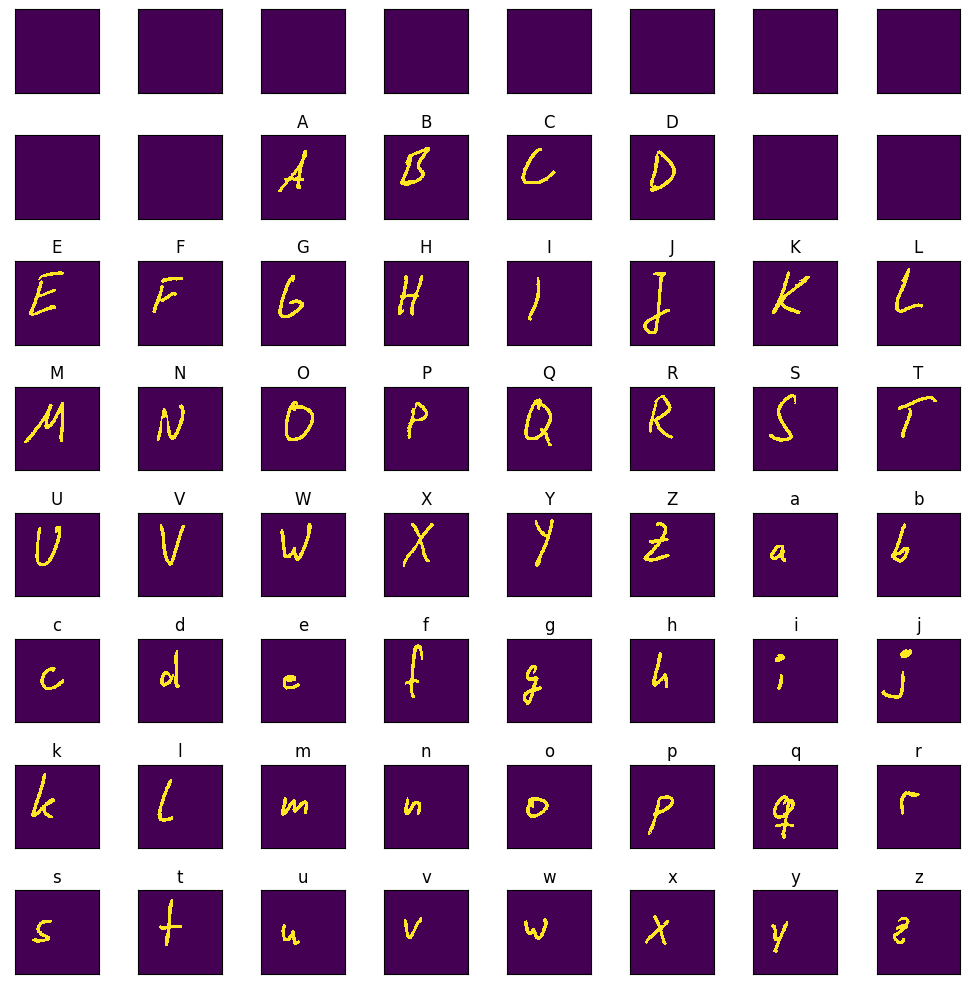

In [71]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
plot_data = image_data[6]
for ax, (x, l) in zip(axs.flat, plot_data):
    ax.imshow(x, interpolation='nearest')
    ax.set_title(l)

plt.tight_layout()
plt.show()

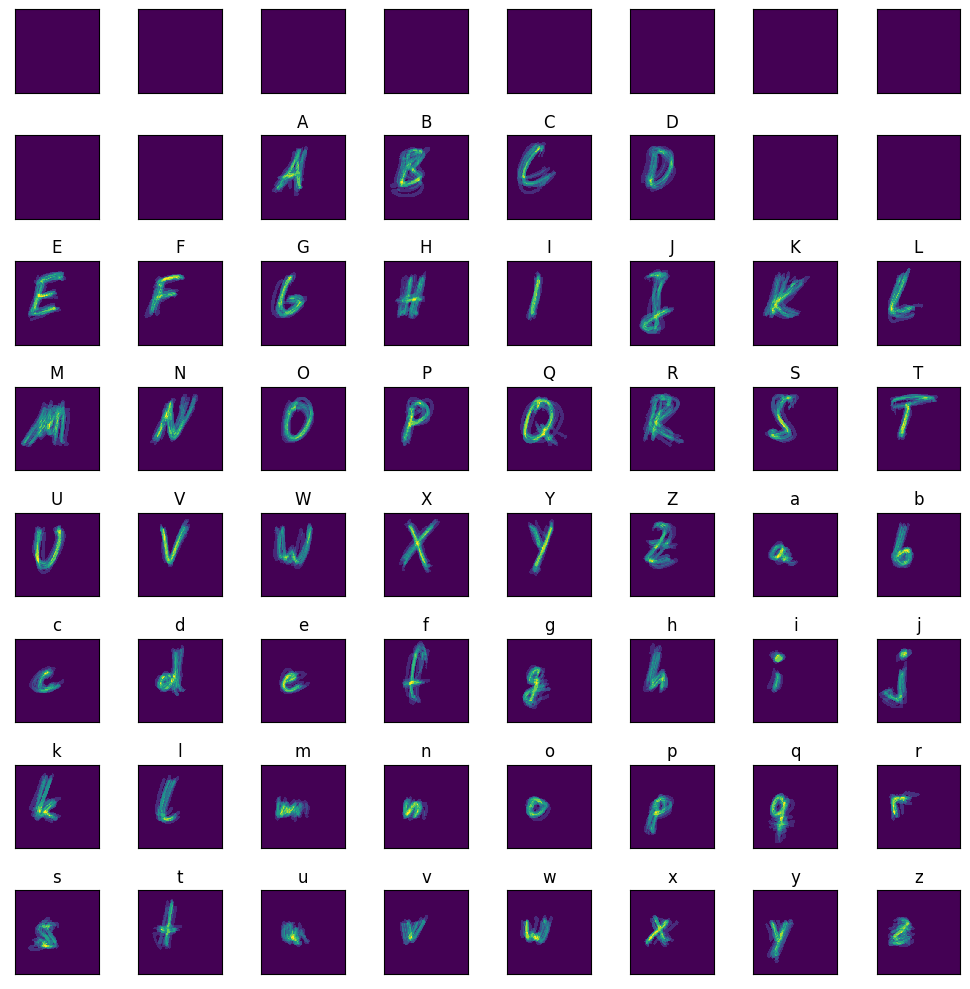

In [72]:
def img_avg(imgs):
    M, _ = imgs[0][0]
    h, w = M.shape
    result = []
    lIndex = 0
    for l in labels:
        avg_matrix = np.zeros([h, w]).astype(float)
        for y in range(h):
            for x in range(w):
                sum = 0
                for i in range(len(imgs)):
                    value, _ = imgs[i][lIndex]
                    sum += value[y][x]
                avg_matrix[y][x] = float(sum) / float(len(imgs))
        result.append((avg_matrix, l))
        lIndex += 1
    return result

avg = img_avg(image_data)
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
for ax, (x, l) in zip(axs.flat, avg):
    ax.imshow(x, interpolation='nearest')
    ax.set_title(l)

plt.tight_layout()
plt.show()

[(196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (196.67740083700517, ''), (35.23063341559725, 'A'), (38.14138739084835, 'B'), (34.659187227332076, 'C'), (37.88057908222812, 'D'), (196.67740083700517, ''), (196.67740083700517, ''), (36.971293501984434, 'E'), (39.29910626320171, 'F'), (35.412385362144654, 'G'), (36.85641140600092, 'H'), (35.90625654756089, 'I'), (40.75461043372809, 'J'), (37.59169858451644, 'K'), (35.08684111961472, 'L'), (36.691069320765706, 'M'), (34.54269142473119, 'N'), (36.09452610597367, 'O'), (38.129085492492834, 'P'), (40.70171531556907, 'Q'), (36.611743376769425, 'R'), (34.442473061864824, 'S'), (39.83050509097856, 'T'), (37.45268620144227, 'U'), (38.71532698053675, 'V'), (33.24191166822427, 'W'), (38.82979637365812, 'X'), (35.95951083862357, 'Y'), (36.47661182013131, 'Z'), (32.

<BarContainer object of 64 artists>

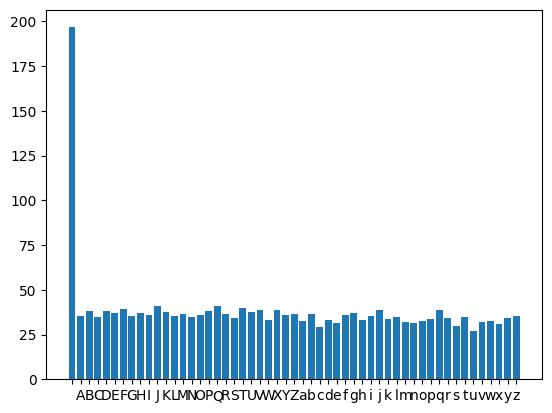

In [73]:
def eukl_dist(img_i, img_j):
    i = img_i.reshape(-1)
    j = img_j.reshape(-1)
    result = np.zeros([len(i)]).astype(float)
    for x in range(len(i)):
        result[x] = (i[x] - j[x])**2
    return np.sqrt(result.sum())

def manh_dist(img_i, img_j):
    i = img_i.reshape(-1)
    j = img_j.reshape(-1)
    result = np.zeros([len(i)]).astype(float)
    for x in range(len(i)):
        result[x] = abs(i[x] - j[x])
    return result.sum()

def get_dists_to_traindata(letter):
    dists = []
    for img_avg in avg:
        x_avg, label = img_avg
        dist = eukl_dist(x_avg, letter)
        dists.append((dist, label))
    return dists

A = test_data[10]
u = test_data[58]
# plt.imshow(A, interpolation='nearest')

dist_out = get_dists_to_traindata(u)
print(dist_out)

dist_values, dist_labels = [], []
for x in dist_out:
    value, label = x
    dist_values.append(value)
    dist_labels.append(label)
plt.bar(dist_labels, dist_values)

1.0

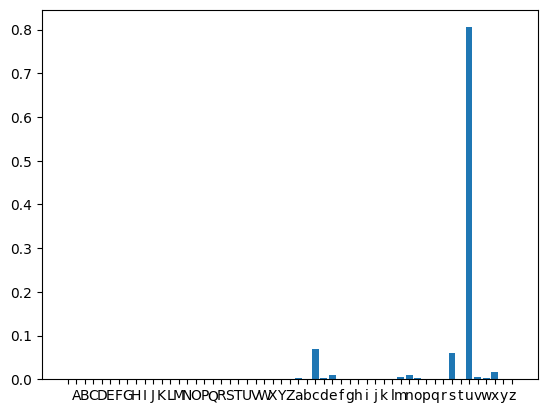

In [74]:
dist_values = np.array(dist_values)

def softmax(values):
    return np.exp(-values) / np.sum(np.exp(-values))

def softmax_labels(values):
    vs = []
    lbs = []
    for x in values:
        value, label = x
        vs.append(value)
        lbs.append(label)
    vs = np.array(vs)
    lbs = np.array(lbs)
    vs = np.exp(-vs) / np.sum(np.exp(-vs))

    output = []
    for x in range(len(vs)):
        output.append((vs[x], lbs[x]))
    return output

norm_values = softmax(dist_values)

plt.bar(dist_labels, norm_values)
np.sum(norm_values)

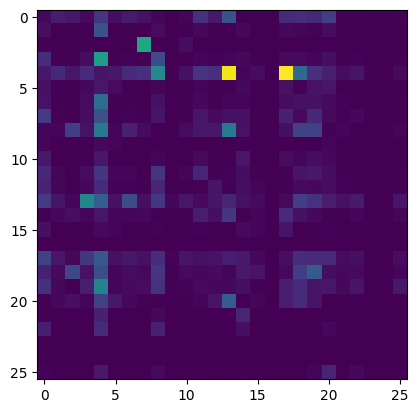

In [75]:
character_labels = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
character_transition_data = genfromtxt('character_transitions.csv', delimiter=',')
character_transition_data = character_transition_data / 10000

plt.imshow(character_transition_data, interpolation='nearest')

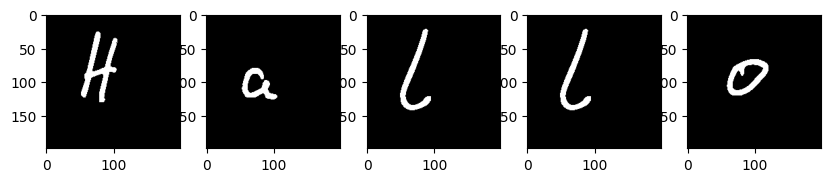

In [76]:
H = test_data[19]
a = test_data[38]
l = test_data[49]
o = test_data[52]

test_hallo = [H, a, l, l, o]

fig = plt.figure(figsize=(10, 2))
for i in range(5):  
    x = test_hallo[i]
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(x, cmap='gray')

0.9999999999999998

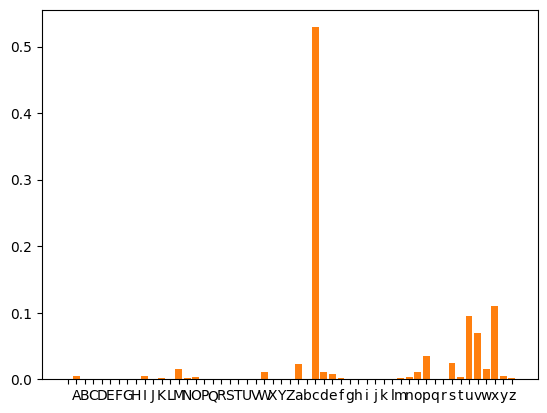

In [83]:
firstLetter = (np.Infinity, "None")

dist_out = softmax_labels(get_dists_to_traindata(o))
for dp in dist_out:
    v1, l1 = dp
    v2, l2 = firstLetter
    if (v1 < v2):
        firstLetter = dp
    
firstLetter

dist_values, dist_labels = [], []
for x in dist_out:
    value, label = x
    dist_values.append(value)
    dist_labels.append(label)
plt.bar(dist_labels, dist_values)

plt.bar(dist_labels, dist_values)
np.sum(dist_values)